# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

np.random.seed(42)
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

feat_info.set_index("attribute", inplace=True)

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape

(891221, 85)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#Change the options so we can check 100 row & column.
pd.set_option("display.max_rows", 100, "display.max_columns", 300)

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sort_values(ascending=False)


KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
ANZ_HAUSHALTE_AKTIV       93148
GEBAEUDE

In [8]:
azdias.isnull().sum().sum()

4896838

In [9]:
for x in feat_info.index:
    
    if x in ["CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CAMEO_INTL_2015", "OST_WEST_KZ"]:
        for y in feat_info.loc[x, "missing_or_unknown"][1:-1].split(","):
            azdias[x].replace({y:np.nan}, inplace=True)
            
    else:
        for y in feat_info.loc[x, "missing_or_unknown"][1:-1].split(","):
            if y == "":
                pass
            else:
                azdias[x].replace({int(y):np.nan}, inplace=True)


In [10]:
azdias.isnull().sum().sum()

8373929

In [11]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sort_values(ascending=False)


TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

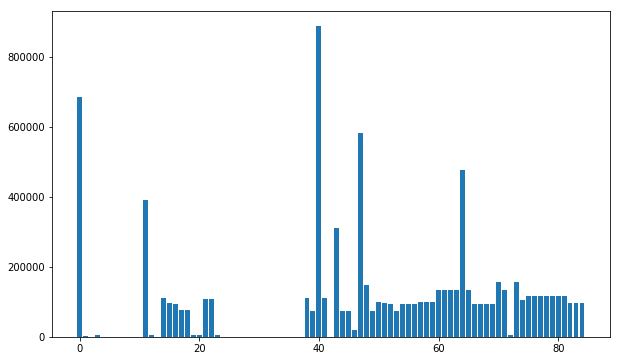

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

plt.figure(figsize=(10,6))
plt.bar(range(azdias.shape[1]) ,azdias.isnull().sum())
plt.show()

In [13]:
# Investigate patterns in the amount of missing data in each column.
n_columns_with_missing = sum(azdias.isnull().sum().sort_values(ascending=False) != 0)

In [14]:
#This is all the columns with missing data

columns_with_missing = azdias.isnull().sum().sort_values(ascending=False)[:n_columns_with_missing] 

In [15]:
n_unique_missing_counts = azdias.isnull().sum().sort_values(ascending=False).unique()[:-1]

print(f'There are {len(n_unique_missing_counts)} unique values for the counts of missing data: \n {n_unique_missing_counts}')

There are 30 unique values for the counts of missing data: 
 [889061 685843 584612 476524 392318 310267 158064 147988 133324 116515
 111196 108315 108164 105800  99611  99352  97632  97375  97274  97008
  94572  93740  93155  93148  77792  73969  73499  18348   4854   2881]


In [16]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
azdias.isnull().sum().value_counts().sort_values(ascending=False)

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
97375      2
77792      2
158064     2
108164     1
93155      1
584612     1
392318     1
889061     1
147988     1
99611      1
97274      1
108315     1
73969      1
18348      1
97632      1
476524     1
2881       1
105800     1
97008      1
310267     1
94572      1
685843     1
dtype: int64

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

q1, q3= np.percentile(azdias.isnull().sum(),[25,75])
iqr = q3 - q1
lower_fence = q1 - 1.5*(iqr)
higher_fence = q3 + 1.5*(iqr)
print(f"Lower Boundary is: {lower_fence}\nHigher Boundary is: {higher_fence}")

Lower Boundary is: -174772.5
Higher Boundary is: 291287.5


{'whiskers': [<matplotlib.lines.Line2D at 0x29c9f745dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x29c9f751b38>,
 'boxes': [<matplotlib.lines.Line2D at 0x29c9c5c1a90>],
 'medians': [<matplotlib.lines.Line2D at 0x29c9f757438>],
 'fliers': [<matplotlib.lines.Line2D at 0x29c9f757898>],
 'means': []}

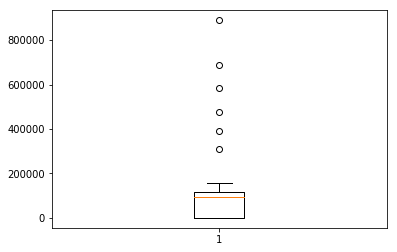

In [19]:
plt.boxplot(azdias.isnull().sum())

In [20]:
outliers_hb = columns_with_missing[columns_with_missing > higher_fence]
print(f"The columns that exceeds the higher boundary is/are:\n{outliers_hb.index.values}")

The columns that exceeds the higher boundary is/are:
['TITEL_KZ' 'AGER_TYP' 'KK_KUNDENTYP' 'KBA05_BAUMAX' 'GEBURTSJAHR'
 'ALTER_HH']


In [21]:
azdias.drop(columns=outliers_hb.index.values, inplace=True)

In [22]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [23]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column


    
##### 1- There are  30 unique values for the counts of missing data: 
 [889061, 685843, 584612, 392318, 310267, 476524, 158064, 147988, 133324, 116515, 111196, 108315, 108164, 105800, 99611,99352,97632, 97375, 97274, 97008, 94572, 93740, 93155, 93148, 77792, 73969, 73499, 18348, 4854, 2881]

##### 2- We found that 6 columns ('TITEL_KZ'  -  'AGER_TYP'  -  'KK_KUNDENTYP'  - 'KBA05_BAUMAX'  - 'GEBURTSJAHR'  - 'ALTER_HH') exceed the higher fence so we dropped it.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
azdias.T.isnull().sum().sum()


5035304

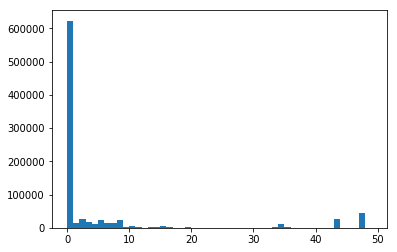

In [25]:
plt.hist(azdias.T.isnull().sum(), bins=max(azdias.T.isnull().sum()))
plt.show()

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

I will consider the threshold to be approximately 20% missing data

In [27]:
threshold = int(azdias.shape[1] * 20 / 100)

print(threshold)

15


In [28]:
rows_below = np.where(azdias.T.isnull().sum() < threshold)

azdias_rows_below = azdias.loc[rows_below]


In [29]:
azdias_rows_below.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [30]:
rows_above = np.where(azdias.T.isnull().sum() >= threshold)

azdias_rows_above = azdias.loc[rows_above]


In [31]:
len(azdias_rows_below)

787544

In [32]:
len(azdias_rows_above)

103677

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

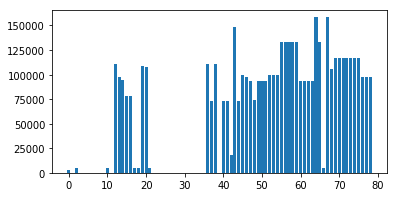

In [34]:
plt.figure(figsize=(6,3))
plt.bar(range(azdias.shape[1]) ,azdias.isnull().sum())
plt.show()

I will choose the columns ranged from 5 to 10 because they have no or little missing data.

In [35]:
def compare(below, above, column):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    ax1 = sns.countplot(below[column].values)
    
    plt.subplot(1, 2, 2)
    ax2 = sns.countplot(above[column].values)
    
    return ax1, ax2

    

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9d6d5c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c9d78cb00>)

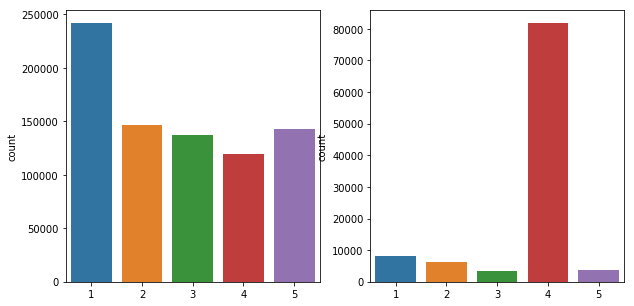

In [36]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[5])

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9d7f96a0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c9d84c0f0>)

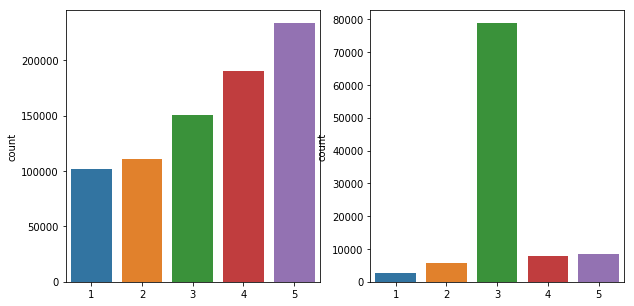

In [37]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[6])

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9d88ea58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c9d73e160>)

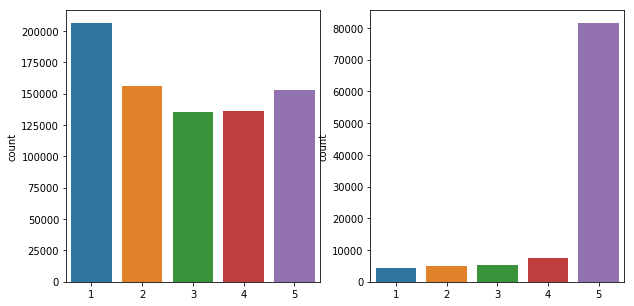

In [38]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[7])

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9d6ba588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29da3f97f60>)

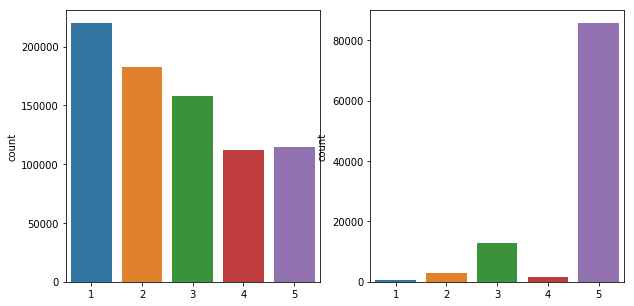

In [39]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[8])

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9d6f5470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c9c64c860>)

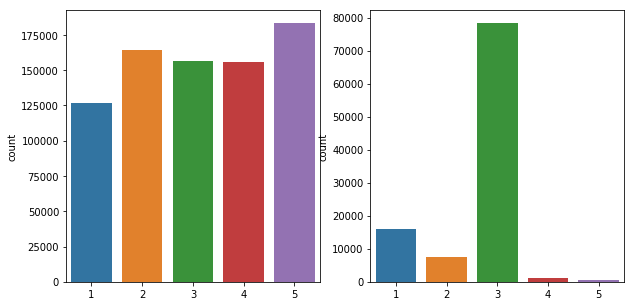

In [40]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[9])

(<matplotlib.axes._subplots.AxesSubplot at 0x29c9f881e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29c9f677588>)

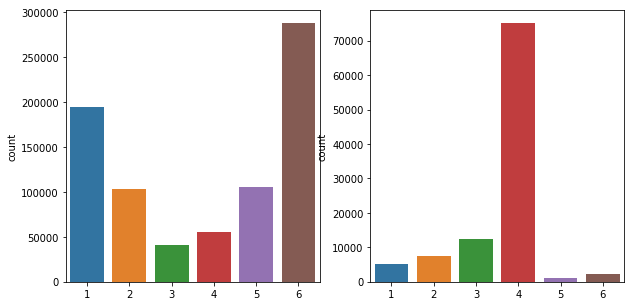

In [41]:
compare(azdias_rows_below, azdias_rows_above, feat_info.index.values[10])

In [42]:
azdias.isnull().sum().sum()

5035304

#### Discussion 1.1.3: Assess Missing Data in Each Row

* I choose the threshold to be 20% of the missing data which is appriximately 15 cells.
* I seperated the data into two data frames, below and above threshold.
* The below threshold dataframe had 787544 rows, while the above threshold dataframe had 103677 rows.
* I choose the five columns ranged from 5 to 10 to compare the two dataframes since they have no or little missing data.
* After analyzing the plots I got to the conclusion that the two dataframes are qualitatively different.
* I decided to keep the rows with missing value above the threshold for now, and seperate it later before useing the imputer.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
azdias["OST_WEST_KZ"].replace({"O":0, "W":1}, inplace=True)
azdias["ANREDE_KZ"].replace({2:0}, inplace=True)
azdias["VERS_TYP"].replace({2:0}, inplace=True)


In [44]:
azdias_rows_above = azdias.loc[rows_above[0]]

azdias.drop(rows_above[0], inplace=True)

In [45]:
# I seperated this column because the imputer doesn't accept CAMEO_DEU_2015, because it has actual strings as values.
CAMEO_DEU_2015 = azdias["CAMEO_DEU_2015"]
azdias.drop(columns=["CAMEO_DEU_2015"], inplace=True)



In [46]:
azdias.shape

(787544, 78)

In [47]:
azdias_rows_above.shape

(103677, 79)

In [48]:
azdias_rows_above.isnull().sum().sum()

4195680

In [49]:
azdias.shape

(787544, 78)

In [50]:
azdias.isnull().sum().sum()

835316

In [51]:

imp = Imputer(missing_values=np.nan ,strategy="most_frequent")
imp = imp.fit(azdias)

filled_azdias = pd.DataFrame(imp.transform(azdias)).iloc[:, :]

filled_azdias.index = azdias.index
filled_azdias.columns = azdias.columns

azdias = filled_azdias.copy()


cleaned_azdias = azdias.copy()

In [52]:
azdias.isnull().sum().sum()

0

In [53]:
CAMEO_DEU_2015.isnull().sum()

4308

In [54]:
CAMEO_DEU_2015_mode = CAMEO_DEU_2015.value_counts().sort_values(ascending=False).index[0]

print(CAMEO_DEU_2015_mode)

CAMEO_DEU_2015.replace({np.nan:CAMEO_DEU_2015_mode}, inplace=True)

cleaned_azdias["CAMEO_DEU_2015"] = CAMEO_DEU_2015

6B


In [55]:
CAMEO_DEU_2015.isnull().sum()

0

In [56]:
azdias_rows_above.shape

(103677, 79)

In [57]:
cleaned_azdias.shape

(787544, 79)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [58]:
outliers_hb

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64

In [59]:

feat_info.drop(outliers_hb.index.values, axis=0, inplace=True)

In [60]:
# How many features are there of each data type
feat_info.iloc[:, 1].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

* Now i will rejoin the rows with missing values count of more than 20%, so that we can perform one hot encoding on it.

In [61]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,0.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,0.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,1.0,4.0,8.0,51.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,0.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,1.0,2.0,4.0,24.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,0.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,4.0,1997.0,1.0,7.0,2.0,12.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,0.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,1.0,3.0,6.0,43.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,0.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1.0,0.0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,0.0,4.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,1.0,7.0,8.0,54.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [62]:
azdias.shape

(787544, 78)

In [63]:
len(azdias.columns.unique())

78

In [64]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_index = np.where(feat_info.iloc[:, 1] == "categorical")

binary_index = []
for i in range(azdias.shape[1]):
    if len(azdias.iloc[:, i].value_counts()) == 2:
        binary_index.append(i)

categorical_names = feat_info.index.values[categorical_index]

binary_names = feat_info.index.values[binary_index]
print(categorical_names)

['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [65]:
categorical_index

(array([ 1,  2,  9, 10, 11, 15, 16, 17, 18, 19, 36, 37, 38, 39, 47, 50, 52,
        53], dtype=int64),)

In [66]:
binary_names

array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP',
       'OST_WEST_KZ'], dtype=object)

In [67]:
azdias[['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP','OST_WEST_KZ']].isnull().sum().sum()

0

In [68]:
categorical_columns = azdias[categorical_names[:-1]]

categorical_columns.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015
1,0.0,5.0,1.0,10.0,0.0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,0.0,5.0,8.0,1.0,8.0
2,0.0,3.0,1.0,10.0,1.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,1.0,4.0
3,0.0,2.0,6.0,1.0,0.0,1.0,1.0,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,1.0,2.0
4,1.0,5.0,5.0,5.0,0.0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,0.0,4.0,1.0,1.0,6.0
5,0.0,2.0,2.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,4.0,1.0,1.0,8.0


In [69]:
azdias_rows_above.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ         float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT 

In [70]:
# I changed the type of the categorical columns to obejcts so that pd.get_dummies accepts them as categorical.
#But I kept the binary columns as int64 so that the there is only one columns with zeros and ones and not column for each value.
categorical_columns = categorical_columns.astype("object")


In [71]:
categorical_columns[binary_names] = categorical_columns[binary_names].astype("int64")


In [72]:
categorical_columns[binary_names]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,0,0,1,0,1
2,0,1,0,1,1
3,0,0,0,1,1
4,1,0,0,0,1
5,0,0,0,0,1
6,0,0,0,1,1
7,1,0,0,1,1
8,1,1,0,0,1
9,0,1,0,0,1
10,0,0,0,0,1


In [73]:
categorical_columns.dtypes

ANREDE_KZ            int64
CJT_GESAMTTYP       object
FINANZTYP           object
GFK_URLAUBERTYP     object
GREEN_AVANTGARDE     int64
LP_FAMILIE_FEIN     object
LP_FAMILIE_GROB     object
LP_STATUS_FEIN      object
LP_STATUS_GROB      object
NATIONALITAET_KZ    object
SHOPPER_TYP         object
SOHO_KZ              int64
VERS_TYP             int64
ZABEOTYP            object
GEBAEUDETYP         object
OST_WEST_KZ          int64
CAMEO_DEUG_2015     object
dtype: object

In [74]:
# Re-encode categorical variable(s) to be kept in the analysis.

categorical_columns = pd.concat([categorical_columns, CAMEO_DEU_2015], axis=1)
categorical_columns = pd.get_dummies(categorical_columns)


In [75]:
categorical_columns.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [76]:
azdias.shape

(787544, 78)

In [77]:

azdias.drop(columns = categorical_names[:-1], inplace=True)


In [78]:
azdias.shape

(787544, 61)

In [79]:

azdias = pd.concat([azdias, categorical_columns], axis=1)

In [80]:
azdias.shape

(787544, 194)

In [81]:
azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

#### Discussion 1.2.1: Re-Encode Categorical Features

* Before applying Re-Encoding I used an imputer to fill in all the missing values.

* The imputer did not accept CAMEO_DEU_2015, so I encoded it manually.

* We have 18 categorical columns, 5 of them are binary.

* I changed the binary columns so that they only have values of 0 & 1

* I used pd.get_dummies to perform one-hot-encoding on the rest of the categorical columns.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [82]:
azdias.shape

(787544, 194)

In [83]:
mixed_features=pd.DataFrame(index = azdias.index)

In [84]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
PRAEGENDE_JUGENDJAHRE_reference = {1: ["40s", 1],
                                  2: ["40s", 0],
                                  3: ["50s", 1],
                                  4: ["50s", 0],
                                  5: ["60s", 1],
                                  6: ["60s", 0],
                                  7: ["60s", 0],
                                  8: ["70s", 1],
                                  9: ["70s", 0],
                                  10: ["80s", 1],
                                  11: ["80s", 0],
                                  12: ["80s", 1],
                                  13: ["80s", 0],
                                  14: ["90s", 1],
                                  15: ["90s", 0]} 

mixed_features["PRAEGENDE_JUGENDJAHRE_GENERATION"] = [PRAEGENDE_JUGENDJAHRE_reference[x][0] for x in azdias["PRAEGENDE_JUGENDJAHRE"]]
mixed_features["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = [PRAEGENDE_JUGENDJAHRE_reference[x][1] for x in azdias["PRAEGENDE_JUGENDJAHRE"]]


In [85]:
mixed_features[["PRAEGENDE_JUGENDJAHRE_GENERATION","PRAEGENDE_JUGENDJAHRE_MOVEMENT"]].head(13)

,PRAEGENDE_JUGENDJAHRE_GENERATION,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,90s,1
2,90s,0
3,70s,1
4,70s,1
5,50s,1
6,80s,1
7,70s,1
8,80s,0
9,90s,0
10,50s,1


In [86]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts()


51.0    137643
41.0     91842
24.0     90154
14.0     62141
43.0     56289
54.0     45220
25.0     39197
22.0     32671
45.0     25959
13.0     25957
23.0     24741
55.0     23789
52.0     20479
34.0     18397
31.0     18148
15.0     16857
44.0     14709
12.0     13046
35.0     10288
32.0     10262
33.0      9755
Name: CAMEO_INTL_2015, dtype: int64

In [87]:

mixed_features["WEALTH"] = [str(x)[0] for x in azdias["CAMEO_INTL_2015"]]
mixed_features["LIFE_STAGE"] = [str(x)[1] for x in azdias["CAMEO_INTL_2015"]]

In [88]:
mixed_features[["WEALTH", "LIFE_STAGE"]].head()

,WEALTH,LIFE_STAGE
1,5,1
2,2,4
3,1,2
4,4,3
5,5,4


i will delete the two original columns with the rest of the mixed columns which are:

In [89]:

azdias = azdias.drop(columns = list(feat_info[feat_info.type == "mixed"].index.values))
azdias.shape

(787544, 188)

In [90]:
mixed_features.dtypes

PRAEGENDE_JUGENDJAHRE_GENERATION    object
PRAEGENDE_JUGENDJAHRE_MOVEMENT       int64
WEALTH                              object
LIFE_STAGE                          object
dtype: object

In [91]:

mixed_features = pd.get_dummies(mixed_features, dtype="int64")

In [92]:
mixed_features.head()

,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GENERATION_40s,PRAEGENDE_JUGENDJAHRE_GENERATION_50s,PRAEGENDE_JUGENDJAHRE_GENERATION_60s,PRAEGENDE_JUGENDJAHRE_GENERATION_70s,PRAEGENDE_JUGENDJAHRE_GENERATION_80s,PRAEGENDE_JUGENDJAHRE_GENERATION_90s,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5
1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [93]:
mixed_features.dtypes

PRAEGENDE_JUGENDJAHRE_MOVEMENT          int64
PRAEGENDE_JUGENDJAHRE_GENERATION_40s    int64
PRAEGENDE_JUGENDJAHRE_GENERATION_50s    int64
PRAEGENDE_JUGENDJAHRE_GENERATION_60s    int64
PRAEGENDE_JUGENDJAHRE_GENERATION_70s    int64
PRAEGENDE_JUGENDJAHRE_GENERATION_80s    int64
PRAEGENDE_JUGENDJAHRE_GENERATION_90s    int64
WEALTH_1                                int64
WEALTH_2                                int64
WEALTH_3                                int64
WEALTH_4                                int64
WEALTH_5                                int64
LIFE_STAGE_1                            int64
LIFE_STAGE_2                            int64
LIFE_STAGE_3                            int64
LIFE_STAGE_4                            int64
LIFE_STAGE_5                            int64
dtype: object

In [94]:
azdias.shape

(787544, 188)

In [95]:

azdias = pd.concat([azdias, mixed_features], axis=1)

In [96]:
azdias.shape

(787544, 205)

In [97]:
azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GENERATION_40s,PRAEGENDE_JUGENDJAHRE_GENERATION_50s,PRAEGENDE_JUGENDJAHRE_GENERATION_60s,PRAEGENDE_JUGENDJAHRE_GENERATION_70s,PRAEGENDE_JUGENDJAHRE_GENERATION_80s,PRAEGENDE_JUGENDJAHRE_GENERATION_90s,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5
1,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
2,3.0,1.0,4.0,1.0,2.0,3.0,5.0,

In [98]:
feat_info.iloc[:, 1].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

* We have 6 mixed feature, i decided to engineer two of them (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015) and drop the rest.
---
* I started by creating a seperate dataframe for the mixed features.
* I refered to the data dictioarty to undersatnd how the two features are constructed.
* I extracted 2 features from PRAEGENDE_JUGENDJAHRE. Generation & Movement.
* I extracted 2 features from CAMEO_INTL_2015. Wealth & Life Stage.
* Then I dropped the initial 2 columns from the dataframe with the rest of the mixed features.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [99]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [100]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [101]:
azdias.dtypes.value_counts()

uint8      128
float64     55
int64       22
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [102]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for x in feat_info.index:

        if x in ["CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CAMEO_INTL_2015", "OST_WEST_KZ"]:
            for y in feat_info.loc[x, "missing_or_unknown"][1:-1].split(","):
                df[x].replace({y:np.nan}, inplace=True)

        else:
            for y in feat_info.loc[x, "missing_or_unknown"][1:-1].split(","):
                if y == "":
                    pass
                else:
                    df[x].replace({int(y):np.nan}, inplace=True)

    # remove selected columns and rows, ...
    
    threshold = int(df.shape[1] * 20 / 100)

    rows_above = np.where(df.T.isnull().sum() >= threshold)

    
    
    df.drop(columns=outliers_hb.index.values, inplace=True)
    
   
    
    # select, re-encode, and engineer column values.
    df["OST_WEST_KZ"].replace({"O":0, "W":1}, inplace=True)
    df["ANREDE_KZ"].replace({2:0}, inplace=True)
    df["VERS_TYP"].replace({2:0}, inplace=True)
    
    df_rows_above = df.loc[rows_above]
    df.drop(df_rows_above.index.values, axis=0, inplace=True)
    
    CAMEO_DEU_2015 = df["CAMEO_DEU_2015"]
    df.drop(columns=["CAMEO_DEU_2015"], inplace=True)


    imp = Imputer(missing_values=np.nan ,strategy="most_frequent")
    imp = imp.fit_transform(df)
    filled_df = pd.DataFrame(imp).iloc[:, :]
    
    filled_df.index = df.index
    filled_df.columns = df.columns

    df = filled_df.copy()
    
    
    CAMEO_DEU_2015_mode = CAMEO_DEU_2015.value_counts().index[0]
    CAMEO_DEU_2015.replace({np.nan:CAMEO_DEU_2015_mode}, inplace=True)
    filled_df["CAMEO_DEU_2015"] = CAMEO_DEU_2015
    ###

    categorical_index = np.where(feat_info.iloc[:, 1] == "categorical")
    categorical_names = feat_info.index.values[categorical_index]

    binary_names = []
    
    for i in range(df.shape[1]):
        if len(df.iloc[:, i].value_counts()) == 2:
            binary_names.append(df.iloc[:, i].name)



    ###
    
    categorical_columns = df[categorical_names[:-1]]

    categorical_columns = pd.concat([categorical_columns, CAMEO_DEU_2015], axis=1)

    categorical_columns = categorical_columns.astype("object")
    
    categorical_columns[binary_names] = categorical_columns[binary_names].astype("int64")

    categorical_columns = pd.get_dummies(categorical_columns, dtype="int64")

    df.drop(columns = categorical_names[:-1], inplace=True)

    df = pd.concat([df, categorical_columns], axis=1)

    mixed_features=pd.DataFrame(index = df.index)
    mixed_features["PRAEGENDE_JUGENDJAHRE_GENERATION"] = [PRAEGENDE_JUGENDJAHRE_reference[x][0] for x in df["PRAEGENDE_JUGENDJAHRE"]]
    mixed_features["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = [PRAEGENDE_JUGENDJAHRE_reference[x][1] for x in df["PRAEGENDE_JUGENDJAHRE"]]
    mixed_features["WEALTH"] = [str(x)[0] for x in df["CAMEO_INTL_2015"]]
    mixed_features["LIFE_STAGE"] = [str(x)[1] for x in df["CAMEO_INTL_2015"]]
    
    df = df.drop(columns = list(feat_info[feat_info.type == "mixed"].index.values))
    mixed_features = pd.get_dummies(mixed_features, dtype="int64")
    df = pd.concat([df, mixed_features], axis=1)
    

    # Return the cleaned dataframe.
    return df, df_rows_above, filled_df
    


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [103]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [104]:
azdias_rows_above.shape

(103677, 79)

In [105]:
cleaned_azdias.shape

(787544, 79)

In [106]:
azdias.shape

(787544, 205)

In [107]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler = scaler.fit(azdias)
X = scaler.transform(azdias)

scaled_azdias = pd.DataFrame(X, columns=azdias.columns, index= azdias.index)

In [108]:
scaled_azdias.head(15)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GENERATION_40s,PRAEGENDE_JUGENDJAHRE_GENERATION_50s,PRAEGENDE_JUGENDJAHRE_GENERATION_60s,PRAEGENDE_JUGENDJAHRE_GENERATION_70s,PRAEGENDE_JUGENDJAHRE_GENERATION_80s,PRAEGENDE_JUGENDJAHRE_GENERATION_90s,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5
1,-1.767361,-1.490890,1.539288,-1.043949,1.467187,0.972646,1.331434,1.007368,-1.683113,0.437686,-0.057282,0.004172,-0.457120,-1.684303,-1.118549,-1.438179,-0.581428,1.276081,-0.309436,1.337499,-0.158151,1.511656,1.290733,0.232184,-0.060623,1.016713,-0.736383,0.558238,0.168612,-0.125588,-1.300747,-0.387253,-1.021871,-0.977559,-0.599956,2.711348,-1.650466,0.846651,-0.550853,1.702973,-0.797406,-0.785125,-1.301510,0.174315,-0.872450,0.968040,-0.257997,0.213149,0.405604,0.430250,1.442647,0.567139,-0.176260,-0.130464,0.681612,-0.958218,-0.531361,10.860312,-0

In [109]:
scaled_azdias

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GENERATION_40s,PRAEGENDE_JUGENDJAHRE_GENERATION_50s,PRAEGENDE_JUGENDJAHRE_GENERATION_60s,PRAEGENDE_JUGENDJAHRE_GENERATION_70s,PRAEGENDE_JUGENDJAHRE_GENERATION_80s,PRAEGENDE_JUGENDJAHRE_GENERATION_90s,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5
1,-1.767361,-1.490890,1.539288,-1.043949,1.467187,0.972646,1.331434,1.007368,-1.683113,0.437686,-0.057282,0.004172,-0.457120,-1.684303,-1.118549,-1.438179,-0.581428,1.276081,-0.309436,1.337499,-0.158151,1.511656,1.290733,0.232184,-0.060623,1.016713,-0.736383,0.558238,0.168612,-0.125588,-1.300747,-0.387253,-1.021871,-0.977559,-0.599956,2.711348,-1.650466,0.846651,-0.550853,1.702973,-0.797406,-0.785125,-1.301510,0.174315,-0.872450,0.968040,-0.257997,0.213149,0.405604,0.430250,1.442647,0.567139,-0.176260,-0.130464,0.681612,-0.958218,-0.531361,10.860312,-0

### Discussion 2.1: Apply Feature Scaling

* Since I've already dealt with the missing data I jumbed into feature scaling.
* I used sklearn's StandardScaler to transfrom the data.
* I didn't transform on the initial scaler variable so that i can use it later.



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [110]:
# Investigate the variance accounted for by each principal component.

Text(0,0.5,'cumulative explained variance')

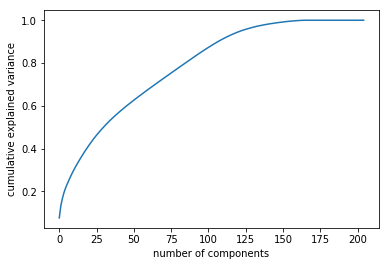

In [111]:

# Apply PCA to the data.

pca = PCA()
pca.fit(scaled_azdias)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


#### I will choose an n_compnents value of 125 which explains 95% of the varaiance

In [112]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(125)
pca.fit(scaled_azdias)
X_pca = pca.transform(scaled_azdias)

sum(pca.explained_variance_ratio_)


0.9554630438316539

In [113]:

pca_dataframe = pd.DataFrame(X_pca)

In [114]:
pca_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
0,5.160401,-3.837484,-3.028862,1.293896,0.795431,-0.214733,0.414619,-1.502711,2.154908,0.667364,-0.248576,-0.248223,1.623205,1.638600,0.754272,-0.712912,-0.875862,-3.029745,0.163603,-4.455290,3.522019,2.769892,0.752382,-2.055128,-0.200156,0.016505,-1.628032,-0.251023,1.461033,1.446456,0.441006,-0.725192,-2.241679,-0.439650,1.830697,-0.160029,-2.494176,-2.414627,-1.320260,-2.292519,-0.622806,-0.078664,2.668597,2.948208,1.087127,0.032708,-1.849497,-0.262016,1.995369,1.708475,1.184160,-2.304402,-1.025088,-4.437126,1.029193,4.702000,-4.445591,2.481920,0.251381,0.911308,-1.201425,1.136778,-1.446518,0.378964,0.863358,1.260366,0.996881,-1.208562,1.190906,1.356639,-0.064730,-1.052473,0.895479,0.040715,-0.440165,1.350143,-0.113774,0.560929,0.063227,0.949783,0.835107,-0.060273,-0.080912,0.281722,-0.447818,0.137329,0.434029,1.922426,0.605822,0.288383,-0.094584,-0.369834,-3.821831,0.187669,1.533753,2.083787,-0.624812,0.402298,-0.766286,2.057378,0.934755,1.857753,1.729136,0.663536,4.195554,1.612509,-1.718771,-0.423816,-1.362206,-0.340687,-0.944923,-0.607807,0.176303,0.559983,2.104120,-1.315464,0.150421,0.554960,0.809589,0.842389,0.324412,-0.028232,0.734021,0.583187,0.623538
1,-0.601904,-0.914102,-3.406447,1.263390,-3.348614,-1.676829,3.280669,-2.010664,-1.053427,0.128562,-2.345004,-0.554205,0.303262,-0.967539,-0.691084,-1.042389,1.255291,0.573836,0.504139,1.539156,0.028533,-0.429966,1.533859,-0.740705,0.686917,0.194176,-0.025984,0.184572,0.637918,-1.628480,1.334239,0.707044,-0.862883,-0.013597,-0.304073,-0.833171,-0.804016,-0.736353,-0.162729,0.280779,2.735160,1.112927,0.284439,1.172842,-0.626718,1.265102,1.415573,-0.926779,1.605166,0.310504,1.810224,-0.307125,0.689570,0.003768,-0.027252,1.078335,0.023529,-0.695952,-1.209325,1.005459,0.382310,-0.538685,-0.419917,0.018768,0.053724,-0.920951,0.588905,-0.335798,-0.625431,0.354876,0.679746,-0.299576,-0.024605,0.289697,-0.511004,0.241862,-0.242659,0.080011,0.151790,-0.128702,-0.129138,0.094462,0.276517,0.171854,-0.120211,-0.095289,-0.387097,-0.383941,0.387149,0.359386,1.001045,0.164153,1.146281,0.557810,0.052661,1.212242,-0.361470,0.831526,-0.787639,-1.712677,-0.531549,0.509949,-0.099450,0.597887,-0.539901,0.391433,0.841507,-0.424142,0.051563,0.003563,-0.472816,-0.410121,0.129463,0.000738,0.834559,-0.998174,-0.136070,-1.874193,0.185503,-0.422645,1.113457,-0.866461,-0.162878,-1.164945,1.525064
2,-4.622508,1.897042,-1.363836,-2.197493,-0.770925,-2.561358,-3.901328,2.659173,1.551293,0.855519,-0.482349,1.160283,-0.390304,0.282455,0.292981,0.119023,0.171589,0.566148,0.589759,0.776235,-0.925283,0.162765,-2.664979,-2.958963,-0.062971,-0.219372,0.375846,-1.932205,0.826743,0.599248,-0.485937,-0.989695,-0.052979,-0.910920,0.867237,-1.148580,-1.083404,1.392827,0.410433,0.096388,-0.535509,-0.354681,1.048770,-0.412075,-0.471316,0.563230,-1.111539,0.302914,-0.574502,0.069445,0.694192,0.521903,-1.350135,-0.059498,0.995133,-2.286771,-0.368328,1.160003,-2.258905,-0.784040,1.003623,-1.293133,0.509689,0.191385,1.391589,-2.095955,1.739143,-0.354448,-0.403401,0.400947,0.023450,2.826637,2.017042,-0.072134,1.946207,-0.145881,-0.347816,-1.131401,-0.633645,0.391859,-0.110612,0.287949,-0.327139,-0.429862,0.165995,-0.730553,0.256055,-0.936604,0.235814,2.191558,-0.746951,-0.716604,0.699027,0.825206,-0.422794,0.787117,-0.591051,0.311616,-0.283690,0.255714,0.153944,0.248898,-0.510815,-0.903226,0.667227,0.643182,1.200627,0.346125,-1.140844,0.363130,-0.143148,-0.413779,-0.408858,-0.492550,-0.118441,-0.964644,0.481126,0.779011,-0.690852,0.102943,0.312280,0.637161,0.005270,-0.866270,0.119016
3,-0.460793,0.368817,3.008569,0.635056,2.074300,5.625

In [115]:
pca_dataframe.shape

(787544, 125)

### Discussion 2.2: Perform Dimensionality Reduction

* After analyzing the variance obrianed by each principal component, I decided to go with 125 principal components to achive 95% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [116]:
def map_weights(component):
    weights = pd.DataFrame(pca.components_,columns=azdias.columns, index=range(1, pca.n_components_+1)).loc[component].T.sort_values(ascending=False)
    return weights.iloc[[1, 2, 3, -3, -2, -1]]

In [117]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_weights(1)

HH_EINKOMMEN_SCORE    0.183184
PLZ8_ANTG3            0.179724
PLZ8_ANTG4            0.172976
PLZ8_ANTG1           -0.180863
MOBI_REGIO           -0.188254
FINANZ_MINIMALIST    -0.189621
Name: 1, dtype: float64

In [118]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(2)

FINANZ_VORSORGER         0.216427
ZABEOTYP_3.0             0.197443
SEMIO_ERL                0.175680
SEMIO_REL               -0.210535
FINANZ_UNAUFFAELLIGER   -0.214025
FINANZ_SPARER           -0.224583
Name: 2, dtype: float64

In [119]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(3)


SEMIO_VERT    0.316966
SEMIO_FAM     0.259889
SEMIO_SOZ     0.256386
SEMIO_KRIT   -0.265313
SEMIO_DOM    -0.279050
SEMIO_KAEM   -0.311810
Name: 3, dtype: float64

### Discussion 2.3: Interpret Principal Components

* First Principal Component.
> * There is a positive correlation between having low income & having a large family of 6-10 or 10+
 * There is a negative correlation between having low income & having a family of 1-2 members.
 * There is a positive correlation between having low financial interest & having high movement pattern & having a family of 1-2 members
 
 HH_EINKOMMEN_SCORE    0.183184
PLZ8_ANTG3            0.179724
PLZ8_ANTG4            0.172976
PLZ8_ANTG1           -0.180863
MOBI_REGIO           -0.188254
FINANZ_MINIMALIST    -0.189621
 
 ---
* Second Principal Component.
> * There is a positive correlation between being dreamful & being family-minded & being socially-minded.
 * There is a negative correlation between being dreamful & and being always willing to fight
 * There is a positive correlation between being willing to fight & having a dominant-mind & having a critical mind.
 
SEMIO_VERT    0.316966
SEMIO_FAM     0.259889
SEMIO_SOZ     0.256386
SEMIO_KRIT   -0.265313
SEMIO_DOM    -0.279050
SEMIO_KAEM   -0.311810

---
* Third Principal Component.
> * There is a positive correlation between being a top earner & having large density of household per km^2
 * There is a negative correlation between being a top earner & Avantgarde type of movement.
 * There is a positive correlation between having Avantgarde type of movement & being house owners.

LP_STATUS_GROB_5.0                0.230809
LP_STATUS_FEIN_10.0               0.230809
EWDICHTE                          0.198163
LP_STATUS_FEIN_9.0               -0.175793
LP_STATUS_GROB_4.0               -0.186879
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.276363



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [120]:
# Over a number of different cluster counts...

scores=[]
n_clusters = range(2, 20)
for i in n_clusters:
    
    # run k-means clustering on the data and...
    model = KMeans(i).fit(pca_dataframe)
    
    # compute the average within-cluster distances.
    scores.append(abs(model.score(pca_dataframe)))

print(scores)
    

[144832098.20331898, 140222776.829005, 137218084.91332114, 134805985.78219044, 133272293.88534983, 132012363.10504419, 130726620.3935944, 129827992.49600488, 129083944.4526817, 127884551.45931481, 127008378.69113116, 125569315.34514953, 124743031.90774497, 123920202.48364973, 123123736.98069757, 122395802.70592786, 121646177.87703262, 120585100.97014777]


([<matplotlib.axis.XTick at 0x29d12f68588>,
 <a list of 18 Text xticklabel objects>)

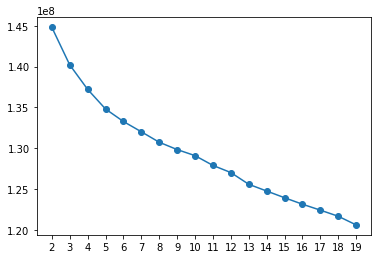

In [121]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters, scores , marker='o')
plt.xticks(n_clusters)


In [122]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(13).fit(pca_dataframe)



In [123]:
labels = model.predict(pca_dataframe)

In [124]:
cleaned_azdias["label"] = labels

In [125]:
azdias_rows_above["label"] = [13] * azdias_rows_above.shape[0]

In [126]:
copy = azdias.copy()

In [127]:
azdias_results = pd.concat([cleaned_azdias, azdias_rows_above], axis=0)

C:\Users\Yazeed Al-Sulayhim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [128]:
azdias_results.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,KBA13_ANZAHL_PKW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,label
1,1.0,0.0,11.0,0.0,2.0,0.0,3.0,6.0,8,8A,51,5.0,3.0,1.0,5.0,5.0,1.0,5.0,4.0,2.0,8.0,3.0,10.0,0.0,3.0,6.0,8.0,0.0,0.0,0.0,2.0,1.0,963.0,2.0,1.0,5.0,3.0,21.0,6.0,2.0,1.0,1992.0,1.0,1.0,3.0,5.0,1.0,2.0,3.0,2.0,1.0,1.0,4.0,5.0,14.0,3.0,4.0,1.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,0.0,9.0,4.0,3.0,5.0,8
2,3.0,0.0,10.0,0.0,1.0,0.0,3.0,2.0,4,4C,24,3.0,4.0,1.0,2.0,5.0,1.0,4.0,3.0,1.0,1.0,4.0,10.0,1.0,3.0,4.0,4.0,1.0,3.0,1.0,0.0,3.0,712.0,2.0,5.0,1.0,1.0,3.0,1.0,3.0,2.0,1992.0,3.0,1.0,2.0,5.0,1.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,15.0,2.0,2.0,3.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,1.0,9.0,2.0,3.0,5.0,10
3,4.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,2,2A,12,2.0,2.0,6.0,2.0,2.0,4.0,2.0,1.0,5.0,1.0,4.0,1.0,0.0,2.0,1.0,6.0,4.0,1.0,0.0,0.0,4.0,596.0,3.0,4.0,1.0,1.0,1.0,2.0,9.0,4.0,1997.0,4.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,0.0,1.0,4.0,3.0,8.0,6.0,3.0,2.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,9.0,7.0,6.0,3.0,7
4,3.0,1.0,3.0,0.0,4.0,0.0,4.0,2.0,6,6B,43,5.0,5.0,5.0,1.0,2.0,4.0,3.0,3.0,4.0,1.0,5.0,5.0,0.0,3.0,5.0,1.0,1.0,4.0,1.0,0.0,3.0,435.0,3.0,4.0,10.0,5.0,32.0,10.0,3.0,2.0,1992.0,3.0,1.0,5.0,6.0,1.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,8.0,5.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,0.0,9.0,3.0,2.0,4.0,2
5,1.0,0.0,5.0,0.0,1.0,0.0,2.0,6.0,8,8C,54,2.0,2.0,2.0,2.0,5.0,3.0,1.0,2.0,5.0,1.0,4.0,1.0,0.0,3.0,5.0,7.0,2.0,2.0,0.0,0.0,4.0,1300.0,4.0,5.0,1.0,1.0,8.0,2.0,4.0,2.0,1992.0,4.0,1.0,1.0,3.0,1.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,3.0,5.0,3.0,3.0,4.0,2.0,4.0,4.0,4.0,5.0,2.0,4.0,7.0,7.0,7.0,2.0,6.0,2.0,0.0,0.0,0.0,9.0,7.0,6.0,4.0,10


In [129]:
azdias_results.shape

(891221, 80)

### Discussion 3.1: Apply Clustering to General Population

* After plotting the number of clusters against the scores and using the elbow method i got to the conclusion that 13 clusters will be a good fit.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [130]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [131]:
customers, customer_rows_above, cleaned_customers = clean_data(customers)
customers.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_GENERATION_40s,PRAEGENDE_JUGENDJAHRE_GENERATION_50s,PRAEGENDE_JUGENDJAHRE_GENERATION_60s,PRAEGENDE_JUGENDJAHRE_GENERATION_70s,PRAEGENDE_JUGENDJAHRE_GENERATION_80s,PRAEGENDE_JUGENDJAHRE_GENERATION_90s,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,2.0,1.

In [132]:
azdias.shape

(787544, 205)

In [133]:
customers.shape

(140678, 204)

In [134]:
customer_rows_above.shape

(50974, 79)

In [135]:
cleaned_customers.shape

(140678, 79)

The only missing column was "GEBAEUDETYP_5.0" since there was no values regestired for 5. so i created a new column filled with zeroes so that i can use sklearn's previous objects on the customers dataset without worrying about misdimenstions.



In [136]:
customers["GEBAEUDETYP_5.0"] = [0] * customers.shape[0]


In [137]:
customers.shape

(140678, 205)

In [138]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
X_customers = scaler.transform(customers)

customers = pd.DataFrame(X_customers, columns=customers.columns, index= customers.index)

X_pca_customers = pca.transform(customers)



In [139]:
customers_pca_dataframe = pd.DataFrame(X_pca_customers)

In [140]:
customers_labels = model.predict(customers_pca_dataframe)

In [141]:
cleaned_customers["label"] = customers_labels

In [142]:
cleaned_customers.shape

(140678, 80)

In [143]:
cleaned_azdias.shape

(787544, 80)

In [144]:
customer_rows_above["label"] = [13] * customer_rows_above.shape[0]

In [145]:
customers_results=pd.concat([cleaned_customers, customer_rows_above])

C:\Users\Yazeed Al-Sulayhim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [146]:
customers_results.shape

(191652, 80)

In [147]:
customers_results["label"].value_counts(normalize=True).sort_index()*100

0      3.501137
1     13.628869
2      7.847557
3      3.237639
4      8.826415
5      3.411391
6      0.630831
7      1.795442
8      0.565608
9      1.446893
10     0.925636
11     0.424206
12    27.161209
13    26.597166
Name: label, dtype: float64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [148]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_clusters = pd.DataFrame(azdias_results["label"].value_counts(normalize=True) * 100).sort_index()
customers_clusters = pd.DataFrame(customers_results["label"].value_counts(normalize=True)  * 100).sort_index()

clusters = pd.concat([azdias_clusters, customers_clusters], axis=1)
clusters.columns = ["Azdias", "Customers"]

In [149]:
clusters

,Azdias,Customers
0,5.233270,3.501137
1,10.723266,13.628869
2,11.381128,7.847557
3,3.471305,3.237639
4,14.023121,8.826415
5,3.530550,3.411391
6,8.011032,0.630831
7,1.459234,1.795442
8,10.478434,0.565608
9,0.357936,1.446893


In [157]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


cluster12 = customers_results[customers_results["label"] == 12]

In [158]:
cluster12.mode().T

,0
ALTERSKATEGORIE_GROB,4
ANREDE_KZ,1
ANZ_HAUSHALTE_AKTIV,1
ANZ_HH_TITEL,0
ANZ_PERSONEN,2
ANZ_TITEL,0
ARBEIT,3
BALLRAUM,6
CAMEO_DEUG_2015,1
CAMEO_DEU_2015,2D


In [159]:
cluster12["OST_WEST_KZ"].value_counts(normalize=True).sort_values()

0.0    0.042955
1.0    0.957045
Name: OST_WEST_KZ, dtype: float64

In [160]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster10 = customers_results[azdias_results["label"] == 10]



C:\Users\Yazeed Al-Sulayhim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
cluster10.mode().T

,0
ALTERSKATEGORIE_GROB,4
ANREDE_KZ,1
ANZ_HAUSHALTE_AKTIV,1
ANZ_HH_TITEL,0
ANZ_PERSONEN,2
ANZ_TITEL,0
ARBEIT,3
BALLRAUM,6
CAMEO_DEUG_2015,2
CAMEO_DEU_2015,2D


In [162]:
# each feature was observed like this:
cluster10["INNENSTADT"].value_counts(normalize=True).sort_index()

1.0    0.044206
2.0    0.104978
3.0    0.108106
4.0    0.192714
5.0    0.194912
6.0    0.141746
7.0    0.080636
8.0    0.132702
Name: INNENSTADT, dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

##### After comparing the population and customers data I got to the conclusion that our target cluster is 12, and they have the following properties.

1. Most of them are old, > 60 years.
2. almost 75% of them are male.
3. Their prefered information channel is Advertising.
4. 43% of them have a tendency to invest.
5. 30% of them are money savers
6. 95% of them are members of green avantgrade.
7. 37% of them are top earners at retirement age from multiperson households.
8. 90% of them are top earners.
9. 90% of them have a multiperson household.
10. 53% of have a return type that is determined Minimal-Returner.
11. They consider themselves religious, event oriented, rational, critical-minded, dominant-minded, and have a combative attitude.
12. They don't consider themselves dreamful, socially-minded, family-minded, materialistic, nor sensual-minded.
13. 41% of them are demanding shoppers.
14. 96% of them live on west of germany.
15. 35% of them have an average neighborhood quality.
16. 22% of them are considered upper class.
17. 30% of them are 50-100km far from the nearest urban center.
18. 25% of them are 5-10km far from the city center.
19. 62% of them live in reigons with low business share compared.
20. 65% of them have a high/very high purchasing power in region
21. 77% of them have a low/very low mevement pattern.
22. 71% of them have a high online affinity.


#### And the cluster that we should avoid is cluster 10 and they have the following properties

1. Most of them are old, > 60 years.
2. Almost 60% of them are male
3. Their prefered information channel is Advertising. **
4. 24% of them are investors.
5. 22% of them are money savers
6. 63% of them are not members of a green avantgrade.
7. 18% of them are top earners at retirement age from multiperson households.
8. 30% of them are top earners.
9. 32% of them are couples, 30% are multiperson families.
10. 43% of them have a return type that is ncentive-receptive Normal-Returner.
11. They consider themselves socially minded, dreamful, and traditional minded.
12. They don't consider themselves religious, event oriented, critical-minded, dominant-minded, family-minded, materialistic, nor sensual-minded.
13. 35% of them are demanding shopper.
14. 56% of them have an energy consumption type that is "fair supplied".
15. 31% of them have average neighborhood quality.
16. 98% of them have no porfessional academic titles in their household.
17. 65% of them are considered high earners.
18. 50% of them have no children in the household.
19. 86% of them have been living in the same residence for more than 10 years
20. 91% of them live in west germany.
21. 33% of them are 50-100km far from the nearest urban center.
22. they tend to be +5km far from the city center.
23. Their neighborhoods have low business share.
24. 60% of them have low movement patterns.
25. 50% of them have low to middle online affinity.
26. 88% of them are not considered upper class.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.